In [5]:
from __future__ import annotations
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
data = pd.read_csv("../data/Credit.csv")

cat_columns = list(data.select_dtypes(include=["object"]).columns)
le = LabelEncoder()
for col in cat_columns:
    data[col] = le.fit_transform(data[col])

X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:, :-1],
    data.iloc[:, -1],
    test_size=0.3,
    random_state=0
)

num_columns = list(set(data.columns) - set(cat_columns))
scaler = MinMaxScaler()
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

In [7]:
class Individual:
    def __init__(self, generation: int=0) -> None:
        self.generation = generation
        self.gene = [0 if np.random.random() < 0.5 else 1 for _ in range(12)]
        self.eval = 0
    
    def _evaluate(self, X_train, X_test, y_train, y_test) -> None:
        self.model = keras.Sequential()
        self.model.add(keras.layers.Input(shape=(20, )))
        for _ in range(int("".join(map(str, self.gene[0:3])), 2) + 1):
            self.model.add(keras.layers.Dense(int("".join(map(str, self.gene[3:7])), 2) + 1, activation="relu"))
        for _ in range(int("".join(map(str, self.gene[7:9])), 2) + 1):
            self.model.add(keras.layers.Dense(int("".join(map(str, self.gene[9:12])), 2) + 1, activation="relu"))
        self.model.add(keras.layers.Dense(1, activation="sigmoid"))

        self.model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        self.model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=False)

        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=False)

        self.loss = loss
        self.eval = accuracy

    def crossover(self, other_individual: Individual) -> list[Individual]:
        cut = round(np.random.rand() * len(self.gene))
        child1 = other_individual.gene[0:cut] + self.gene[cut::]
        child2 = self.gene[0:cut] + other_individual.gene[cut::]

        children = [Individual(self.generation + 1), Individual(self.generation + 1)]
        
        children[0].gene = child1
        children[1].gene = child2
        
        return children

    def mutation(self, mutation_rate: float) -> Individual:
        for i in range(len(self.gene)):
            if np.random.random() < mutation_rate:
                if self.gene[i]:
                    self.gene[i] = 0
                else:
                    self.gene[i] = 1
        return self
    
    def __repr__(self):
        return f"""Generation: {self.generation}
Gene: {self.gene}
{int("".join(map(str, self.gene[0:3])), 2) + 1} camadas com {int("".join(map(str, self.gene[3:7])), 2) + 1} neurons
{int("".join(map(str, self.gene[7:9])), 2) + 1} camadas com {int("".join(map(str, self.gene[9:12])), 2) + 1} neurons
"""

In [24]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, X_train, X_test, y_train, y_test) -> None:
        self.population_size = population_size
        self.population = []
        self.generation = 0
        self.eval_sum = 0
        self.best_solution = 0
        self.solution_list = []
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.pareto = []

    def init_population(self) -> None:
        for _ in range(self.population_size):
            self.population.append(Individual())
        self.best_solution = self.population[0]

    def sort_population(self) -> None:
        self.population = sorted(self.population, key=lambda individual: individual.eval, reverse=True)

    def best_individual(self, individual: Individual) -> None:
        if individual.eval > self.best_solution.eval:
            self.best_solution = individual
    
    def sum_eval(self) -> float:
        sum = 0
        for individual in self.population:
            sum += individual.eval
        return sum

    def select_parent(self, sum_eval:float) -> int:
        parent = -1
        value = np.random.rand() * sum_eval
        sum = 0
        i = 0
        while i < len(self.population) and sum < value:
            sum += self.population[i].eval
            parent += 1
            i += 1
        return parent

    def visualize_generation(self) -> None:
        best = self.population[0]
        print(f"G:{self.population[0].generation} -> ",
              f"Eval: {round(best.eval, 2)}",
              f" Gene: {best.gene}")

    def solve(self, mutation_rate=0.05, generations=0) -> list[int]:
        self.init_population()

        print("Generation 0")

        for i in tqdm(range(len(self.population))):
            self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)
        
        self.sort_population()

        self.best_solution = self.population[0]
        self.solution_list.append(self.best_solution.eval)

        self.visualize_generation()

        for i in range(generations):
            print(f"Generation {i + 1}")
            eval_sum = self.sum_eval()
            new_population = []

            for _ in range(0, self.population_size, 2):
                parent1 = self.select_parent(eval_sum)
                parent2 = self.select_parent(eval_sum)

                children = self.population[parent1].crossover(self.population[parent2])

                new_population.append(children[0].mutation(mutation_rate))   
                new_population.append(children[1].mutation(mutation_rate))

            self.population = list(new_population)

            for i in tqdm(range(len(self.population))):
                self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)
            
            pareto = []
            for individual in self.population:
                frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.population)

                if frontier:
                    pareto.append(individual)

            self.pareto.extend(pareto)
            

            self.sort_population()
            self.visualize_generation()

            self.solution_list.append(self.population[0].eval)

            self.best_individual(self.population[0])
        
        self.pareto_frontier = []
        for individual in self.pareto:
            frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.pareto)

            if frontier:
                self.pareto_frontier.append(individual)

        print(f"Best Solution -> G:{self.best_solution.generation} -> ",
              f"Eval: {round(self.best_solution.eval, 3)}",
              f" Gene: {self.best_solution.gene}")
        
        return self.best_solution

ga = GeneticAlgorithm(6, X_train, X_test, y_train, y_test)

In [5]:
result = ga.solve(generations=10)

Generation 0
G:0 ->  Eval: 0.73  Gene: [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Generation 1
G:1 ->  Eval: 0.71  Gene: [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Generation 2
G:2 ->  Eval: 0.71  Gene: [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
Generation 3
G:3 ->  Eval: 0.71  Gene: [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Generation 4
G:4 ->  Eval: 0.74  Gene: [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Generation 5
G:5 ->  Eval: 0.71  Gene: [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Generation 6
G:6 ->  Eval: 0.71  Gene: [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]
Generation 7
G:7 ->  Eval: 0.71  Gene: [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]
Generation 8
G:8 ->  Eval: 0.71  Gene: [0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]
Generation 9
G:9 ->  Eval: 0.72  Gene: [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
Generation 10
G:10 ->  Eval: 0.71  Gene: [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
Best Solution -> G:4 ->  Eval: 0.737  Gene: [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]


In [6]:
result

Generation: 4
Gene: [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
2 camadas com 11 neurons
1 camadas com 2 neurons

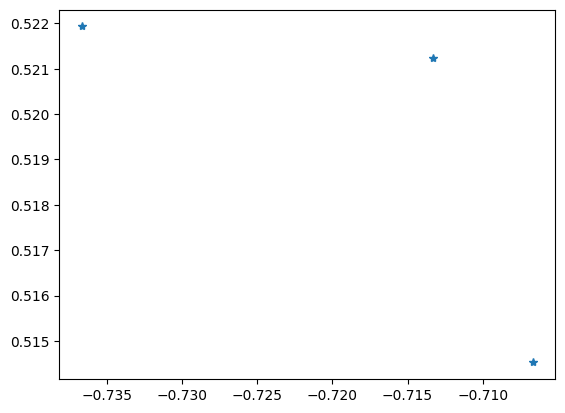

In [7]:
loss = []
acc = []
for individual in ga.pareto_frontier:
    loss.append(individual.loss)
    acc.append(-individual.eval)
plt.plot(acc, loss, marker="*", linestyle="None")

In [8]:
ga2 = GeneticAlgorithm(6, X_train, X_test, y_train, y_test)
result2 = ga2.solve(generations=10)
result2

Generation 0
G:0 ->  Eval: 0.71  Gene: [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]
Generation 1
G:1 ->  Eval: 0.72  Gene: [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]
Generation 2
G:2 ->  Eval: 0.71  Gene: [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0]
Generation 3
G:3 ->  Eval: 0.71  Gene: [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]
Generation 4
G:4 ->  Eval: 0.71  Gene: [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0]
Generation 5
G:5 ->  Eval: 0.71  Gene: [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0]
Generation 6
G:6 ->  Eval: 0.73  Gene: [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]
Generation 7
G:7 ->  Eval: 0.74  Gene: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]
Generation 8
G:8 ->  Eval: 0.73  Gene: [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]
Generation 9
G:9 ->  Eval: 0.71  Gene: [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Generation 10
G:10 ->  Eval: 0.72  Gene: [1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]
Best Solution -> G:7 ->  Eval: 0.74  Gene: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]


Generation: 7
Gene: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]
5 camadas com 10 neurons
1 camadas com 4 neurons

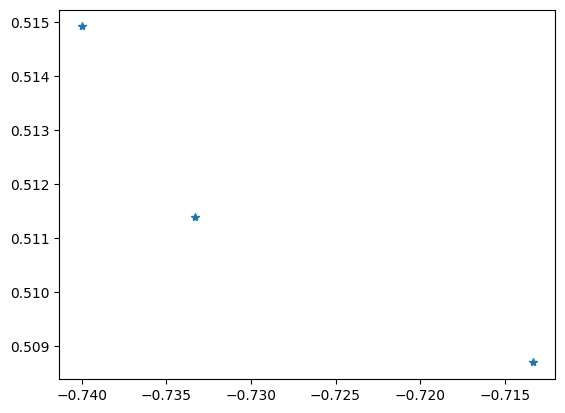

In [9]:
loss = []
acc = []
for individual in ga2.pareto_frontier:
    loss.append(individual.loss)
    acc.append(-individual.eval)
plt.plot(acc, loss, marker="*", linestyle="None")

In [10]:
ga3 = GeneticAlgorithm(6, X_train, X_test, y_train, y_test)
result3 = ga3.solve(generations=10)
result3

Generation 0
G:0 ->  Eval: 0.72  Gene: [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
Generation 1
G:1 ->  Eval: 0.71  Gene: [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
Generation 2
G:2 ->  Eval: 0.71  Gene: [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Generation 3
G:3 ->  Eval: 0.71  Gene: [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]
Generation 4
G:4 ->  Eval: 0.71  Gene: [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]
Generation 5
G:5 ->  Eval: 0.71  Gene: [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]
Generation 6
G:6 ->  Eval: 0.71  Gene: [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
Generation 7
G:7 ->  Eval: 0.71  Gene: [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Generation 8
G:8 ->  Eval: 0.71  Gene: [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Generation 9
G:9 ->  Eval: 0.71  Gene: [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
Generation 10
G:10 ->  Eval: 0.74  Gene: [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
Best Solution -> G:10 ->  Eval: 0.74  Gene: [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]


Generation: 10
Gene: [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
7 camadas com 9 neurons
3 camadas com 4 neurons

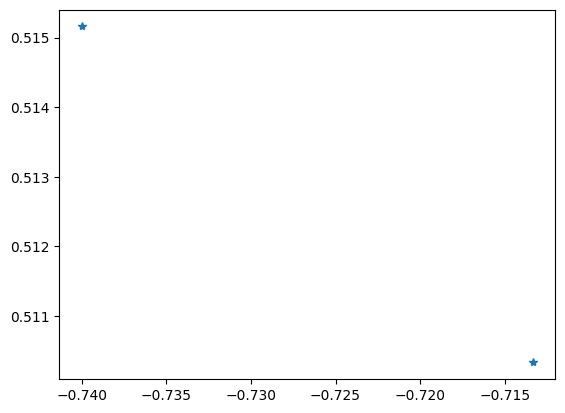

In [11]:
loss = []
acc = []
for individual in ga3.pareto_frontier:
    loss.append(individual.loss)
    acc.append(-individual.eval)
plt.plot(acc, loss, marker="*", linestyle="None")

In [4]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, X_train, X_test, y_train, y_test) -> None:
        self.population_size = population_size
        self.population = []
        self.generation = 0
        self.eval_sum = 0
        self.best_solution = 0
        self.solution_list = []
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.pareto = []

    def init_population(self) -> None:
        for _ in range(self.population_size):
            self.population.append(Individual())
        self.best_solution = self.population[0]

    def sort_population(self) -> None:
        self.population = sorted(self.population, key=lambda individual: individual.eval, reverse=True)

    def best_individual(self, individual: Individual) -> None:
        if individual.eval > self.best_solution.eval:
            self.best_solution = individual
    
    def sum_eval(self) -> float:
        sum = 0
        for individual in self.population:
            sum += individual.eval
        return sum

    def select_parent(self, sum_eval:float) -> int:
        parent = -1
        value = np.random.rand() * sum_eval
        sum = 0
        i = 0
        while i < len(self.population) and sum < value:
            sum += self.population[i].eval
            parent += 1
            i += 1
        return parent

    def visualize_generation(self) -> None:
        best = self.population[0]
        print(f"G:{self.population[0].generation} -> ",
              f"Eval: {round(best.eval, 2)}",
              f" Gene: {best.gene}")

    def solve(self, mutation_rate=0.05, generations=0) -> list[int]:
        self.init_population()

        print("Generation 0")

        for i in tqdm(range(len(self.population))):
            self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)
        
        self.sort_population()

        self.best_solution = self.population[0]
        self.solution_list.append(self.best_solution.eval)

        self.visualize_generation()

        for i in range(generations):
            print(f"Generation {i + 1}")
            eval_sum = self.sum_eval()
            new_population = []

            for _ in range(0, self.population_size, 2):
                parent1 = self.select_parent(eval_sum)
                parent2 = self.select_parent(eval_sum)

                children = self.population[parent1].crossover(self.population[parent2])

                new_population.append(children[0].mutation(mutation_rate))   
                new_population.append(children[1].mutation(mutation_rate))

            self.population = list(new_population)

            for i in tqdm(range(len(self.population))):
                self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)
            
            pareto = []
            for individual in self.population:
                frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.population)

                if frontier:
                    pareto.append(individual)

            self.pareto.extend(pareto)
            

            self.sort_population()
            self.visualize_generation()

            self.solution_list.append(self.population[0].eval)

            self.best_individual(self.population[0])
        
        self.pareto_frontier = []
        for individual in self.pareto:
            frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.pareto)

            if frontier:
                self.pareto_frontier.append(individual)

        print(f"Best Solution -> G:{self.best_solution.generation} -> ",
              f"Eval: {round(self.best_solution.eval, 3)}",
              f" Gene: {self.best_solution.gene}")
        
        return self.best_solution

In [27]:
ga4 = GeneticAlgorithm(20, X_train, X_test, y_train, y_test)
result4 = ga4.solve(generations=20)
result4

Generation 0


100%|██████████| 20/20 [01:06<00:00,  3.34s/it]


G:0 ->  Eval: 0.74  Gene: [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
Generation 1


100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


G:1 ->  Eval: 0.73  Gene: [0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
Generation 2


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


G:2 ->  Eval: 0.72  Gene: [1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]
Generation 3


100%|██████████| 20/20 [01:11<00:00,  3.57s/it]


G:3 ->  Eval: 0.72  Gene: [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Generation 4


100%|██████████| 20/20 [01:06<00:00,  3.30s/it]


G:4 ->  Eval: 0.72  Gene: [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
Generation 5


100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


G:5 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0]
Generation 6


100%|██████████| 20/20 [01:05<00:00,  3.29s/it]


G:6 ->  Eval: 0.73  Gene: [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1]
Generation 7


100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


G:7 ->  Eval: 0.72  Gene: [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]
Generation 8


100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


G:8 ->  Eval: 0.72  Gene: [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Generation 9


100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


G:9 ->  Eval: 0.72  Gene: [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Generation 10


100%|██████████| 20/20 [01:20<00:00,  4.02s/it]


G:10 ->  Eval: 0.72  Gene: [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Generation 11


100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


G:11 ->  Eval: 0.72  Gene: [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
Generation 12


100%|██████████| 20/20 [01:15<00:00,  3.79s/it]


G:12 ->  Eval: 0.72  Gene: [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
Generation 13


100%|██████████| 20/20 [01:15<00:00,  3.79s/it]


G:13 ->  Eval: 0.72  Gene: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
Generation 14


100%|██████████| 20/20 [01:18<00:00,  3.92s/it]


G:14 ->  Eval: 0.72  Gene: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
Generation 15


100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


G:15 ->  Eval: 0.73  Gene: [1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1]
Generation 16


100%|██████████| 20/20 [01:20<00:00,  4.05s/it]


G:16 ->  Eval: 0.73  Gene: [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
Generation 17


100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


G:17 ->  Eval: 0.73  Gene: [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
Generation 18


100%|██████████| 20/20 [01:20<00:00,  4.05s/it]


G:18 ->  Eval: 0.71  Gene: [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1]
Generation 19


100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


G:19 ->  Eval: 0.72  Gene: [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Generation 20


100%|██████████| 20/20 [01:24<00:00,  4.23s/it]

G:20 ->  Eval: 0.71  Gene: [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
Best Solution -> G:0 ->  Eval: 0.74  Gene: [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]


Generation: 0
Gene: [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
4 camadas com 16 neurons
1 camadas com 4 neurons

In [6]:
loss = []
acc = []
for individual in ga4.pareto_frontier:
    loss.append(individual.loss)
    acc.append(-individual.eval)
plt.plot(acc, loss, marker="*", linestyle="None")

NameError: name 'ga4' is not defined

In [5]:
ga5 = GeneticAlgorithm(25, X_train, X_test, y_train, y_test)
result5 = ga5.solve(generations=30)
result5

Generation 0


100%|██████████| 25/25 [01:29<00:00,  3.60s/it]


G:0 ->  Eval: 0.73  Gene: [1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]
Generation 1


100%|██████████| 26/26 [01:37<00:00,  3.76s/it]


G:1 ->  Eval: 0.72  Gene: [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]
Generation 2


100%|██████████| 26/26 [01:39<00:00,  3.84s/it]


G:2 ->  Eval: 0.73  Gene: [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]
Generation 3


100%|██████████| 26/26 [01:36<00:00,  3.72s/it]


G:3 ->  Eval: 0.74  Gene: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Generation 4


100%|██████████| 26/26 [01:38<00:00,  3.79s/it]


G:4 ->  Eval: 0.71  Gene: [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Generation 5


100%|██████████| 26/26 [01:36<00:00,  3.72s/it]


G:5 ->  Eval: 0.72  Gene: [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Generation 6


100%|██████████| 26/26 [01:34<00:00,  3.65s/it]


G:6 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]
Generation 7


100%|██████████| 26/26 [01:33<00:00,  3.61s/it]


G:7 ->  Eval: 0.72  Gene: [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]
Generation 8


100%|██████████| 26/26 [01:38<00:00,  3.78s/it]


G:8 ->  Eval: 0.72  Gene: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]
Generation 9


100%|██████████| 26/26 [01:38<00:00,  3.77s/it]


G:9 ->  Eval: 0.72  Gene: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Generation 10


100%|██████████| 26/26 [01:30<00:00,  3.50s/it]


G:10 ->  Eval: 0.72  Gene: [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Generation 11


100%|██████████| 26/26 [01:38<00:00,  3.79s/it]


G:11 ->  Eval: 0.72  Gene: [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]
Generation 12


100%|██████████| 26/26 [01:32<00:00,  3.55s/it]


G:12 ->  Eval: 0.72  Gene: [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
Generation 13


100%|██████████| 26/26 [01:36<00:00,  3.70s/it]


G:13 ->  Eval: 0.74  Gene: [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
Generation 14


100%|██████████| 26/26 [01:38<00:00,  3.79s/it]


G:14 ->  Eval: 0.73  Gene: [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
Generation 15


100%|██████████| 26/26 [01:37<00:00,  3.75s/it]


G:15 ->  Eval: 0.72  Gene: [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
Generation 16


100%|██████████| 26/26 [01:31<00:00,  3.51s/it]


G:16 ->  Eval: 0.73  Gene: [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 17


100%|██████████| 26/26 [01:30<00:00,  3.49s/it]


G:17 ->  Eval: 0.71  Gene: [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0]
Generation 18


100%|██████████| 26/26 [01:27<00:00,  3.38s/it]


G:18 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
Generation 19


100%|██████████| 26/26 [01:23<00:00,  3.22s/it]


G:19 ->  Eval: 0.73  Gene: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
Generation 20


100%|██████████| 26/26 [01:28<00:00,  3.41s/it]


G:20 ->  Eval: 0.74  Gene: [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
Generation 21


100%|██████████| 26/26 [01:24<00:00,  3.26s/it]


G:21 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Generation 22


100%|██████████| 26/26 [01:26<00:00,  3.33s/it]


G:22 ->  Eval: 0.75  Gene: [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Generation 23


100%|██████████| 26/26 [01:22<00:00,  3.18s/it]


G:23 ->  Eval: 0.73  Gene: [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Generation 24


100%|██████████| 26/26 [01:23<00:00,  3.22s/it]


G:24 ->  Eval: 0.73  Gene: [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
Generation 25


100%|██████████| 26/26 [01:33<00:00,  3.58s/it]


G:25 ->  Eval: 0.72  Gene: [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Generation 26


100%|██████████| 26/26 [01:25<00:00,  3.30s/it]


G:26 ->  Eval: 0.72  Gene: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Generation 27


100%|██████████| 26/26 [01:27<00:00,  3.36s/it]


G:27 ->  Eval: 0.72  Gene: [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Generation 28


100%|██████████| 26/26 [01:28<00:00,  3.41s/it]


G:28 ->  Eval: 0.71  Gene: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]
Generation 29


100%|██████████| 26/26 [01:25<00:00,  3.27s/it]


G:29 ->  Eval: 0.73  Gene: [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Generation 30


100%|██████████| 26/26 [01:27<00:00,  3.35s/it]

G:30 ->  Eval: 0.73  Gene: [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Best Solution -> G:22 ->  Eval: 0.747  Gene: [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1]


Generation: 22
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1]
5 camadas com 14 neurons
1 camadas com 4 neurons

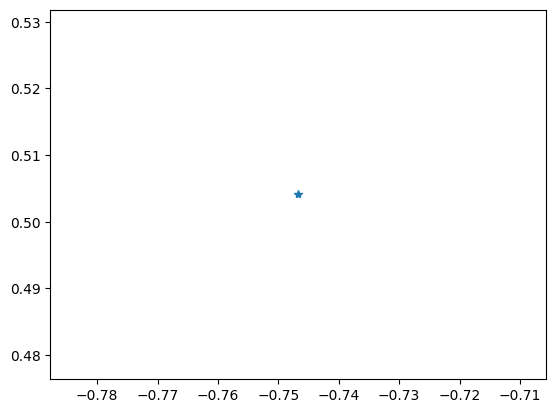

In [7]:
loss = []
acc = []
for individual in ga5.pareto_frontier:
    loss.append(individual.loss)
    acc.append(-individual.eval)
plt.plot(acc, loss, marker="*", linestyle="None")

In [8]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, X_train, X_test, y_train, y_test) -> None:
        self.population_size = population_size
        self.population = []
        self.generation = 0
        self.eval_sum = 0
        self.best_solution = 0
        self.solution_list = []
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.pareto = []

    def init_population(self) -> None:
        for _ in range(self.population_size):
            self.population.append(Individual())
        self.best_solution = self.population[0]

    def sort_population(self) -> None:
        self.population = sorted(self.population, key=lambda individual: individual.eval, reverse=True)

    def best_individual(self, individual: Individual) -> None:
        if individual.eval > self.best_solution.eval:
            self.best_solution = individual
    
    def sum_eval(self) -> float:
        sum = 0
        for individual in self.population:
            sum += individual.eval
        return sum

    def select_parent(self, sum_eval:float) -> int:
        parent = -1
        value = np.random.rand() * sum_eval
        sum = 0
        i = 0
        while i < len(self.population) and sum < value:
            sum += self.population[i].eval
            parent += 1
            i += 1
        return parent

    def visualize_generation(self) -> None:
        best = self.population[0]
        print(f"G:{self.population[0].generation} -> ",
              f"Eval: {round(best.eval, 2)}",
              f" Gene: {best.gene}")

    def solve(self, mutation_rate=0.05, generations=0) -> list[int]:
        self.init_population()

        print("Generation 0")

        for i in tqdm(range(len(self.population))):
            self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)
        
        self.sort_population()

        self.best_solution = self.population[0]
        self.solution_list.append(self.best_solution.eval)

        self.visualize_generation()

        for i in range(generations):
            print(f"Generation {i + 1}")
            eval_sum = self.sum_eval()
            new_population = []

            pareto = []
            for individual in self.population:
                frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.population)

                if frontier:
                    pareto.append(individual)
            self.pareto.append(pareto)

            for _ in range(0, self.population_size, 2):
                parent1 = self.select_parent(eval_sum)
                parent2 = self.select_parent(eval_sum)

                children = self.population[parent1].crossover(self.population[parent2])

                new_population.append(children[0].mutation(mutation_rate))   
                new_population.append(children[1].mutation(mutation_rate))

            self.population = list(new_population)

            for i in tqdm(range(len(self.population))):
                self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)            

            self.sort_population()
            self.visualize_generation()

            self.solution_list.append(self.population[0].eval)

            self.best_individual(self.population[0])
        
        self.pareto = [item for row in self.pareto for item in row]

        self.pareto_frontier = []
        for individual in self.pareto:
            frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.pareto)

            if frontier:
                self.pareto_frontier.append(individual)

        print(f"Best Solution -> G:{self.best_solution.generation} -> ",
              f"Eval: {round(self.best_solution.eval, 3)}",
              f" Gene: {self.best_solution.gene}")
        
        return self.best_solution

In [9]:
ga6 = GeneticAlgorithm(6, X_train, X_test, y_train, y_test)
result6 = ga6.solve(generations=6)
result6

Generation 0


100%|██████████| 6/6 [00:20<00:00,  3.37s/it]


G:0 ->  Eval: 0.71  Gene: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Generation 1


100%|██████████| 6/6 [00:18<00:00,  3.06s/it]


G:1 ->  Eval: 0.72  Gene: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
Generation 2


100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


G:2 ->  Eval: 0.71  Gene: [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
Generation 3


100%|██████████| 6/6 [00:19<00:00,  3.22s/it]


G:3 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1]
Generation 4


100%|██████████| 6/6 [00:18<00:00,  3.07s/it]


G:4 ->  Eval: 0.74  Gene: [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Generation 5


100%|██████████| 6/6 [00:18<00:00,  3.07s/it]


G:5 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Generation 6


100%|██████████| 6/6 [00:19<00:00,  3.23s/it]

G:6 ->  Eval: 0.71  Gene: [0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0]
Best Solution -> G:4 ->  Eval: 0.737  Gene: [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]


Generation: 4
Gene: [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
2 camadas com 11 neurons
1 camadas com 3 neurons

In [37]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, X_train, X_test, y_train, y_test) -> None:
        self.population_size = population_size
        self.population = []
        self.generation = 0
        self.eval_sum = 0
        self.best_solution = 0
        self.solution_list = []
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.pareto = []
        self.frontier = []

    def init_population(self) -> None:
        for _ in range(self.population_size):
            self.population.append(Individual())
        self.best_solution = self.population[0]

    def sort_population(self) -> None:
        self.population = sorted(self.population, key=lambda individual: individual.eval, reverse=True)

    def best_individual(self, individual: Individual) -> None:
        if individual.eval > self.best_solution.eval:
            self.best_solution = individual
    
    def sum_eval(self) -> float:
        sum = 0
        for individual in self.population:
            sum += individual.eval
        return sum

    def select_parent(self, size:int) -> int:
        return np.random.randint(size)

    def visualize_generation(self) -> None:
        best = self.population[0]
        print(f"G:{self.population[0].generation} -> ",
              f"Eval: {round(best.eval, 2)}",
              f" Gene: {best.gene}")

    def solve(self, mutation_rate=0.05, generations=0) -> list[int]:
        self.init_population()

        print("Generation 0")

        for i in tqdm(range(len(self.population))):
            self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)


        for i in range(generations):
            for individual in self.population:
                frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.population)

                if frontier:
                    self.pareto.append(individual)
            self.frontier.append(self.pareto)
            new_population = []
            match len(self.pareto):
                case 0:
                    for _ in range(0, self.population_size, 2):
                        parent1 = self.select_parent(self.population_size)
                        parent2 = self.select_parent(self.population_size)

                        children = self.population[parent1].crossover(self.population[parent2])

                        new_population.append(children[0].mutation(mutation_rate))   
                        new_population.append(children[1].mutation(mutation_rate))
                case 1:
                    for _ in range(0, self.population_size, 2):
                        parent1 = self.select_parent(len(self.pareto))
                        parent2 = self.select_parent(self.population_size)

                        children = self.pareto[parent1].crossover(self.population[parent2])

                        new_population.append(children[0].mutation(mutation_rate))   
                        new_population.append(children[1].mutation(mutation_rate))
                case _:  
                    for _ in range(0, self.population_size, 2):
                        parent1 = self.select_parent(len(self.pareto))
                        parent2 = self.select_parent(len(self.pareto))

                        children = self.pareto[parent1].crossover(self.pareto[parent2])

                        new_population.append(children[0].mutation(mutation_rate))   
                        new_population.append(children[1].mutation(mutation_rate))
                
            print(f"Generation {i + 1}")

            self.population = list(new_population)

            for i in tqdm(range(len(self.population))):
                self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)            
        
        self.frontier = [item for row in self.frontier for item in row]

        self.pareto_frontier = []
        for individual in self.frontier:
            frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.frontier)

            if frontier:
                self.pareto_frontier.append(individual)

In [41]:
ga7 = GeneticAlgorithm(10, X_train, X_test, y_train, y_test)
result7 = ga7.solve(generations=6)
result7

Generation 0


100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


Generation 1


100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


Generation 2


100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


Generation 3


100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


Generation 4


100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


Generation 5


100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


Generation 6


100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


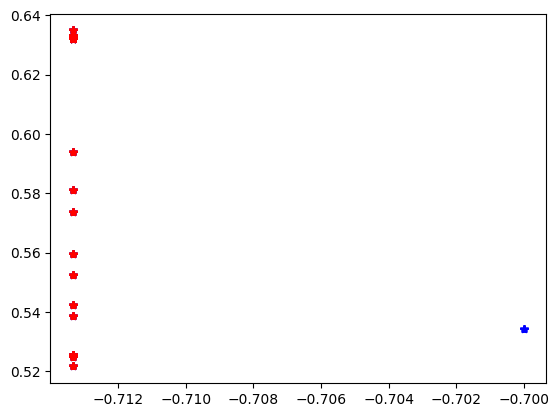

In [47]:
frontier_loss = []
frontier_acc = []
for individual in ga7.pareto_frontier:
    frontier_loss.append(individual.loss)
    frontier_acc.append(-individual.eval)
pareto_loss = []
pareto_acc = []
for individual in ga7.frontier:
    pareto_loss.append(individual.loss)
    pareto_acc.append(-individual.eval)
plt.plot(pareto_acc, pareto_loss, color="blue", marker="*", linestyle="None")
plt.plot(frontier_acc, frontier_loss, color="red", marker="*", linestyle="None")

In [43]:
ga8 = GeneticAlgorithm(10, X_train, X_test, y_train, y_test)
result8 = ga8.solve(generations=6)
result8

Generation 0


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


Generation 1


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Generation 2


100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


Generation 3


100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


Generation 4


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


Generation 5


100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


Generation 6


100%|██████████| 10/10 [00:30<00:00,  3.10s/it]


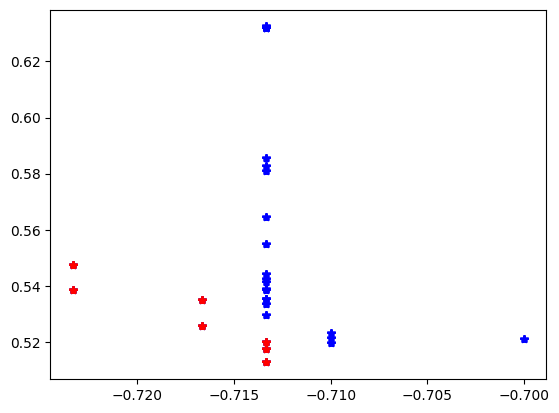

In [46]:
frontier_loss = []
frontier_acc = []
for individual in ga8.pareto_frontier:
    frontier_loss.append(individual.loss)
    frontier_acc.append(-individual.eval)
pareto_loss = []
pareto_acc = []
for individual in ga8.frontier:
    pareto_loss.append(individual.loss)
    pareto_acc.append(-individual.eval)
plt.plot(pareto_acc, pareto_loss, color="blue", marker="*", linestyle="None")
plt.plot(frontier_acc, frontier_loss, color="red", marker="*", linestyle="None")

In [48]:
ga9 = GeneticAlgorithm(10, X_train, X_test, y_train, y_test)
result9 = ga9.solve(generations=8)
result9

Generation 0


100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


Generation 1


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


Generation 2


100%|██████████| 10/10 [00:41<00:00,  4.15s/it]


Generation 3


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


Generation 4


100%|██████████| 10/10 [00:35<00:00,  3.51s/it]


Generation 5


100%|██████████| 10/10 [00:34<00:00,  3.40s/it]


Generation 6


100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


Generation 7


100%|██████████| 10/10 [00:34<00:00,  3.45s/it]


Generation 8


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


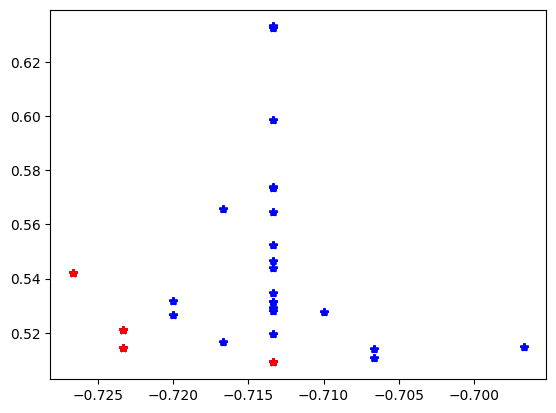

In [49]:
frontier_loss = []
frontier_acc = []
for individual in ga9.pareto_frontier:
    frontier_loss.append(individual.loss)
    frontier_acc.append(-individual.eval)
pareto_loss = []
pareto_acc = []
for individual in ga9.frontier:
    pareto_loss.append(individual.loss)
    pareto_acc.append(-individual.eval)
plt.plot(pareto_acc, pareto_loss, color="blue", marker="*", linestyle="None")
plt.plot(frontier_acc, frontier_loss, color="red", marker="*", linestyle="None")